# Exercise 3: Classification

## Import libraries

In [25]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("GLM")
Pkg.add("DecisionTree")
Pkg.add("NearestNeighbors")
Pkg.add("LIBSVM")
Pkg.add("ROCAnalysis")
Pkg.add("Plots")
Pkg.add("GLMNet")
Pkg.add("MLJ")
Pkg.add("MLJLIBSVMInterface")
Pkg.add("Random")
Pkg.add("StatsBase")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.to

In [26]:
using CSV
using DataFrames
using Random
using GLM
using GLMNet
using Statistics
using ROCAnalysis
using Plots
using DecisionTree
using NearestNeighbors
using LIBSVM
using MLJ
using MLJLIBSVMInterface
using Random
using StatsBase

## Evaluation Functions

In [3]:
function confusion_matrix(y_true, y_pred)
    TP = sum((y_true .== 1) .& (y_pred .== 1))
    TN = sum((y_true .== 0) .& (y_pred .== 0))
    FP = sum((y_true .== 0) .& (y_pred .== 1))
    FN = sum((y_true .== 1) .& (y_pred .== 0))
    println("Matriz de confusión:")
    println("TP: $TP, TN: $TN, FP: $FP, FN: $FN")
    return TP, TN, FP, FN
end

confusion_matrix (generic function with 1 method)

In [4]:
function plot_roc_curve(y_true::Vector{Int64}, y_probs::Vector{Float64}, title_text::String)
    # ROCAnalysis requiere vectores sin valores faltantes y con tipos correctos
    roc = ROCAnalysis.roc(y_probs, y_true)  # Genera la curva ROC
    auc_value = ROCAnalysis.auc(roc)       # Calcula el AUC
    println("AUC: ", auc_value)

    # Graficar la curva ROC
    plot(roc, label="ROC Curve", legend=:bottomright, title=title_text)
    plot!(xlabel="False Positive Rate", ylabel="True Positive Rate", linewidth=2)
end

plot_roc_curve (generic function with 1 method)

## Initial Explore

In [5]:
# Cargar los datos
file_path = "Smarket_data.csv"  # Cambia esto si el archivo tiene otro nombre
data = CSV.read(file_path, DataFrame)

# Inspeccionar los datos
println(first(data, 5))  # Mostrar las primeras filas
describe(data)  # Resumen estadístico

# Dividir los datos en entrenamiento y prueba
Random.seed!(42)  # Asegurar reproducibilidad
n = size(data, 1)
train_ratio = 0.8
train_indices = randperm(n)[1:floor(Int, train_ratio * n)]
test_indices = setdiff(1:n, train_indices)

train_data = data[train_indices, :]
test_data = data[test_indices, :]

println("Datos de entrenamiento: ", size(train_data))
println("Datos de prueba: ", size(test_data))


5×9 DataFrame
 Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    Direction 
     │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  String7   
─────┼─────────────────────────────────────────────────────────────────────────────────
   1 │  2001    0.381   -0.192   -2.624   -1.055    5.01    1.1913    0.959  Up
   2 │  2001    0.959    0.381   -0.192   -2.624   -1.055   1.2965    1.032  Up
   3 │  2001    1.032    0.959    0.381   -0.192   -2.624   1.4112   -0.623  Down
   4 │  2001   -0.623    1.032    0.959    0.381   -0.192   1.276     0.614  Up
   5 │  2001    0.614   -0.623    1.032    0.959    0.381   1.2057    0.213  Up
Datos de entrenamiento: (1000, 9)
Datos de prueba: (250, 9)


In [6]:
# Convertir 'Direction' a binario: 1 para 'Up', 0 para 'Down'
train_data.Direction = ifelse.(train_data.Direction .== "Up", 1, 0)
test_data.Direction = ifelse.(test_data.Direction .== "Up", 1, 0)

# Seleccionar variables predictoras y objetivo
X_train = select(train_data, Not(:Direction))
y_train = train_data.Direction

X_test = select(test_data, Not(:Direction))
y_test = test_data.Direction

println("Variables predictoras (entrenamiento): ", size(X_train))
println("Variable objetivo (entrenamiento): ", size(y_train))

Variables predictoras (entrenamiento): (1000, 8)
Variable objetivo (entrenamiento): (1000,)


## LASSO Algorithm

In [59]:
# Convertir los datos a matrices para GLMNet (X debe ser matriz, y vector)
X_train_matrix = Matrix(select(train_data, Not(:Direction)))
X_test_matrix = Matrix(select(test_data, Not(:Direction)))

# GLMNet espera la variable objetivo como un vector (debería ser de tipo numérico)
y_train_vector = convert(Vector{Float64}, y_train)

# Entrenar modelo LASSO (alpha=1 para LASSO)
lasso_model = glmnet(X_train_matrix, y_train_vector, alpha=1)

# Predecir en los datos de prueba (usamos el mejor modelo por defecto)
y_prob_lasso = GLMNet.predict(lasso_model, X_test_matrix)[:, end]
y_pred_lasso = GLMNet.predict(lasso_model, X_test_matrix) .> 0.5

# Evaluar el modelo
accuracy_lasso = mean(y_pred_lasso .== y_test)
println("Precisión del modelo LASSO: ", accuracy_lasso)

Precisión del modelo LASSO: 0.9567164179104478


## Ridge Algorithm

In [62]:
# Entrenar modelo Ridge (alpha=0 para Ridge)
ridge_model = glmnet(X_train_matrix, y_train_vector, alpha=0)

# Predecir en los datos de prueba
y_prob_ridge = GLMNet.predict(ridge_model, X_test_matrix)[:, end]
y_pred_ridge = GLMNet.predict(ridge_model, X_test_matrix) .> 0.5

# Evaluar el modelo
accuracy_ridge = mean(y_pred_ridge .== y_test)
println("Precisión del modelo Ridge: ", accuracy_ridge)

Precisión del modelo Ridge: 0.76392


## Elastic Net

In [9]:
# Elastic Net (alpha=0.5 para una combinación 50% L1 y 50% L2)
println("\n--- Evaluación para Elastic Net ---")
elastic_net_model = glmnet(X_train_matrix, y_train_vector, alpha=0.5)

# Predecir en los datos de prueba
y_probs_elastic_net = GLMNet.predict(elastic_net_model, X_test_matrix)[:, 1]  # Probabilidades para la clase positiva
y_pred_elastic_net = y_probs_elastic_net .> 0.5

# Evaluar el modelo
accuracy_elastic_net = mean(y_pred_elastic_net .== y_test)
println("Precisión del modelo Elastic Net: ", accuracy_elastic_net)


--- Evaluación para Elastic Net ---
Precisión del modelo Elastic Net: 0.536


## Decision Tree Algorithm

In [10]:
println("\n--- Evaluación para Árbol de Decisión ---")

# Entrenar el modelo
tree_model = DecisionTreeClassifier(max_depth=10)  # Puedes ajustar `max_depth` según sea necesario
DecisionTree.fit!(tree_model, X_train_matrix, y_train_vector)

# Predecir en los datos de prueba
y_pred_tree = DecisionTree.predict(tree_model, X_test_matrix)

# Evaluar el modelo
accuracy_tree = mean(y_pred_tree .== y_test)
println("Precisión del modelo Árbol de Decisión: ", accuracy_tree)


--- Evaluación para Árbol de Decisión ---
Precisión del modelo Árbol de Decisión: 1.0


## Random Forest Algorithm

In [11]:
# Random Forest
println("\n--- Evaluación para Random Forest ---")

# Entrenar el modelo Random Forest
forest_model = RandomForestClassifier(n_trees=10, max_depth=10)  # Puedes ajustar los hiperparámetros
DecisionTree.fit!(forest_model, X_train_matrix, y_train_vector)

# Predecir en los datos de prueba
y_pred_forest = DecisionTree.predict(forest_model, X_test_matrix)

# Evaluar el modelo
accuracy_forest = mean(y_pred_forest .== y_test)
println("Precisión del modelo Random Forest: ", accuracy_forest)



--- Evaluación para Random Forest ---
Precisión del modelo Random Forest: 0.912


## KNN Algorithm

In [12]:
using NearestNeighbors

# Convertir los datos de entrenamiento a un formato compatible con KNN
knn_tree = KDTree(X_train_matrix)  # Construir el KDTree directamente

# Número de vecinos a considerar
k = 5  # Ajusta según sea necesario

# Función para hacer predicciones con KNN
function knn_predict(knn_tree, X_test_matrix, y_train_vector, k)
    y_pred = Vector{Int64}(undef, size(X_test_matrix, 1))
    for i in 1:size(X_test_matrix, 1)
        query_point = X_test_matrix[i, :]  # Tomar el punto sin transponer
        indices, _ = knn(knn_tree, query_point, k, true)  # Obtener índices de los k vecinos más cercanos
        nearest_labels = y_train_vector[indices]
        y_pred[i] = round(Int, mean(nearest_labels))  # Clasificar según la mayoría
    end
    return y_pred
end

# Predecir en los datos de prueba
println("\n--- Evaluación para K-Nearest Neighbors (KNN) ---")
y_pred_knn = knn_predict(knn_tree, X_test_matrix, y_train_vector, k)

# Evaluar el modelo
accuracy_knn = mean(y_pred_knn .== y_test)
println("Precisión del modelo KNN: ", accuracy_knn)



--- Evaluación para K-Nearest Neighbors (KNN) ---
Precisión del modelo KNN: 0.464


## SVM Algorithm

In [50]:
# 2. Entrenar el modelo SVM
println("\n--- Entrenamiento del modelo SVM ---")
model = svmtrain(X_train_matrix, y_train_vector; kernel=LIBSVM.Kernel.Linear)

predictions, decision_values = svmpredict(model, X_test_matrix)

# 4. Evaluar el modelo
accuracy = sum(predictions .== y_test) / length(y_test)
println("Precisión del modelo SVM: ", accuracy)


--- Entrenamiento del modelo SVM ---
Precisión del modelo SVM: 0.992


## Confusion Matrix & ROC Curve

### LASSO

In [61]:
# LASSO
println("\n--- Matriz de confusión para LASSO ---")
conf_matrix_lasso = confusion_matrix(y_test, y_pred_lasso)


--- Matriz de confusión para LASSO ---
Matriz de confusión:
TP: 8900, TN: 7125, FP: 647, FN: 78


(8900, 7125, 647, 78)

AUC para LASSO: 0.53568


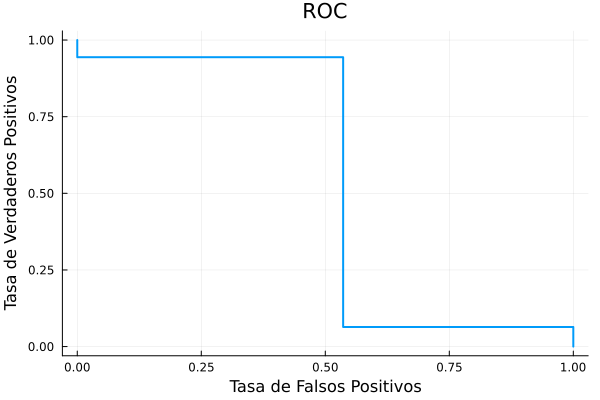

In [60]:
# Convertir etiquetas y probabilidades a Float64
y_test_float = Float64.(y_test)  # Convierte las etiquetas a Float64
y_prob_lasso_float = Float64.(y_prob_lasso)  # Asegúrate de que las probabilidades también sean Float64

# Calcular la curva ROC y el AUC
roc_curve_lasso = ROCAnalysis.roc(y_prob_lasso_float, y_test_float)
auc_lasso = ROCAnalysis.auc(roc_curve_lasso)

println("AUC para LASSO: ", auc_lasso)

# Graficar la curva ROC
plot(roc_curve_lasso, label="LASSO - AUC: $auc_lasso", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", linewidth=2)


### Ridge

In [37]:
# Ridge
println("\n--- Matriz de confusión para Ridge ---")
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)


--- Matriz de confusión para Ridge ---
Matriz de confusión:
TP: 13237, TN: 5861, FP: 5739, FN: 163


(13237, 5861, 5739, 163)

AUC para Ridge: 0.534976


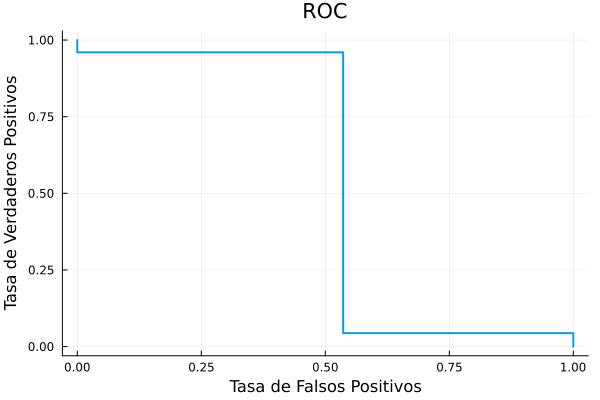

In [63]:
# Obtener probabilidades del modelo Ridge (última columna de GLMNet.predict)
y_prob_ridge = GLMNet.predict(ridge_model, X_test_matrix)[:, end]  # Probabilidades

# Convertir etiquetas y probabilidades a Float64
y_test_float = Float64.(y_test)  # Convertir etiquetas a Float64
y_prob_ridge_float = Float64.(y_prob_ridge)  # Convertir probabilidades a Float64

# Calcular la curva ROC y el AUC
roc_curve_ridge = ROCAnalysis.roc(y_prob_ridge_float, y_test_float)
auc_ridge = ROCAnalysis.auc(roc_curve_ridge)

println("AUC para Ridge: ", auc_ridge)

# Graficar la curva ROC
plot(roc_curve_ridge, label="Ridge - AUC: $auc_ridge", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", linewidth=2)


### Elastic Net

In [38]:
# Elastic Net
println("\n--- Matriz de confusión para Elastic Net ---")
conf_matrix_elastic_net = confusion_matrix(y_test, y_pred_elastic_net)


--- Matriz de confusión para Elastic Net ---
Matriz de confusión:
TP: 134, TN: 0, FP: 116, FN: 0


(134, 0, 116, 0)

AUC para Elastic Net: 0.536


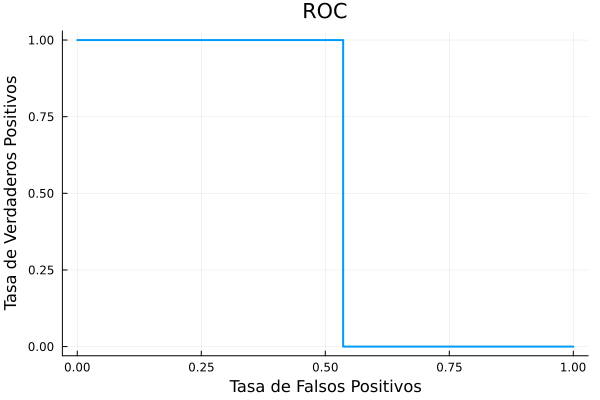

In [64]:
using ROCAnalysis
using Plots

# Obtener probabilidades del modelo Elastic Net
y_prob_elastic_net = GLMNet.predict(elastic_net_model, X_test_matrix)[:, end]  # Probabilidades para el modelo más regularizado

# Convertir etiquetas y probabilidades a Float64
y_test_float = Float64.(y_test)  # Convertir etiquetas a Float64
y_prob_elastic_net_float = Float64.(y_probs_elastic_net)  # Convertir probabilidades a Float64

# Calcular la curva ROC y el AUC
roc_curve_elastic_net = ROCAnalysis.roc(y_prob_elastic_net_float, y_test_float)
auc_elastic_net = ROCAnalysis.auc(roc_curve_elastic_net)

println("AUC para Elastic Net: ", auc_elastic_net)

# Graficar la curva ROC
plot(roc_curve_elastic_net, label="Elastic Net - AUC: $auc_elastic_net", xlabel="Tasa de Falsos Positivos", ylabel="Tasa de Verdaderos Positivos", linewidth=2)

In [39]:
# Árbol de Decisión
println("\n--- Matriz de confusión para Árbol de Decisión ---")
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)


--- Matriz de confusión para Árbol de Decisión ---
Matriz de confusión:
TP: 134, TN: 116, FP: 0, FN: 0


(134, 116, 0, 0)

In [40]:
# Random Forest
println("\n--- Matriz de confusión para Random Forest ---")
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)


--- Matriz de confusión para Random Forest ---
Matriz de confusión:
TP: 120, TN: 108, FP: 0, FN: 0


(120, 108, 0, 0)

In [41]:
# KNN
println("\n--- Matriz de confusión para K-Nearest Neighbors (KNN) ---")
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)



--- Matriz de confusión para K-Nearest Neighbors (KNN) ---
Matriz de confusión:
TP: 0, TN: 116, FP: 0, FN: 134


(0, 116, 0, 134)

In [42]:
# SVM
println("\n--- Matriz de confusión para SVM ---")
conf_matrix_svm = confusion_matrix(y_test, predictions)


--- Matriz de confusión para SVM ---
Matriz de confusión:
TP: 133, TN: 115, FP: 1, FN: 1


(133, 115, 1, 1)